Важное замечание. 
Мы не будем стремиться достичь наивысшего качества предсказания совершения покупки. Наша цель — отработать навыки работы с несбалансированными данными и применение методов валидации для оценки качества моделей.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли

plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.csv') # прочитаем
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
print(shoppers_data.shape) # размер таблицы

(12330, 18)


In [4]:
shoppers_data.isna().sum() # проверим наличие пропусков

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [5]:
dummy_data = pd.get_dummies(shoppers_data) # кодировка категориальных признаков
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


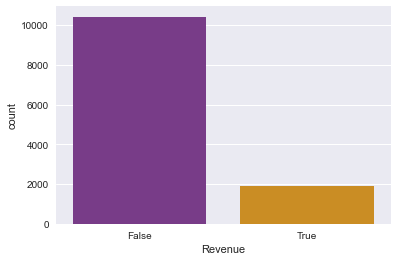

In [6]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

## Условимся, что лучшей будет считаться та модель, у которой значение метрики F1 для пользователей, совершивших покупку, будет наибольшим.

In [7]:
# разделим набор данных на матрицу наблюдений X и вектор ответов y:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

Разделим выборку на тренировочную и тестовую.
Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).
Итого мы будем использовать три показателя:

значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).
Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

## Задание 6.2
Для начала позаботимся о создании отложенной тестовой выборки.
Разделите выборку на тренировочную и тестовую в соотношении 80/20. Используйте разбиение, стратифицированное по целевому признаку. В качестве значения параметра random_state возьмите число 42.
Чему равно количество сессий на сайте в тренировочной и тестовой выборках?

In [8]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train:', X_train.shape)
print('Valid:', X_test.shape)

Train: (9864, 28)
Valid: (2466, 28)


## Задание 6.3
Коллеги посоветовали нам использовать случайный лес (Random Forest) для решения данной задачи. Давайте последуем их совету.
Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.
Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).
Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — F1-score.
Чему равно среднее значение метрики  на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [9]:
model_rf = ensemble.RandomForestClassifier(random_state=42)
model_rf.fit(X,y)

skf = model_selection.StratifiedKFold(n_splits=5)
#Считаем метрики на кросс-валидации k-fold
metrics = model_selection.cross_validate(
    estimator=model_rf, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)

print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(metrics['test_score'])))

Train k-fold mean accuracy: 1.00
Valid k-fold mean accuracy: 0.65


## Задание 6.5
Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создайте список из трёх следующих моделей:
Случайный лес из деревьев максимальной глубины 5.
Случайный лес из деревьев максимальной глубины 7.
Случайный лес из деревьев максимальной глубины 12.
Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмите равным 200, количество объектов в листе (min_samples_leaf) — 5. Параметр random_state = 42. Остальные параметры оставьте по умолчанию.

Постройте для каждой из моделей кривую обучения.

Совет: воспользуйтесь функцией plot_learning_curve(), которую мы создали в юните по кривым обучения.

Для построения кривых используйте обучающий набор данных (X_train, y_train), стратифицированный кросс-валидатор на пяти фолдов (StratifiedKFold) и метрику F1-score. Остальные параметры функции learning_curve() оставьте по умолчанию.

Из построенных кривых обучения сделайте вывод: какая глубина деревьев в лесу является оптимальной?

Ответ: 7

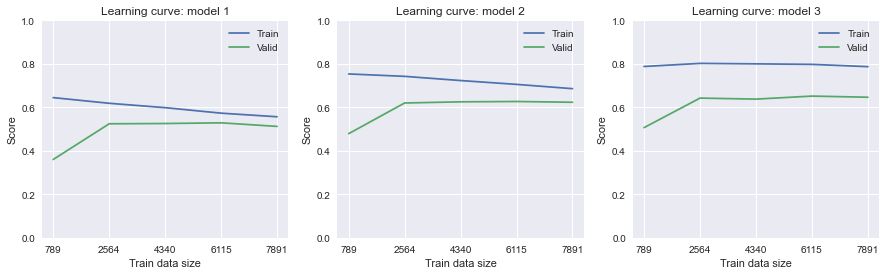

In [10]:
models = [
    ensemble.RandomForestClassifier(
        n_estimators=200, # количество деревьев в лесу
        max_depth=5, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200, # количество деревьев в лесу
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, 
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200, # количество деревьев в лесу
        max_depth=12, #максимальная глубина 
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42
    ),
]
skf = model_selection.StratifiedKFold(n_splits=5)

def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()
    
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости

for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    model.fit(X, y)
    plot_learning_curve(model, X_train, y_train, skf, ax=axes[i], title=f'model {i+1}')

## Задание 6.6
Обучите случайный лес с выбранной в предыдущем задании оптимальной глубиной на тренировочной выборке. Сделайте предсказание меток классов и выведите отчёт о метриках классификации.

Ответьте на следующие вопросы:

1. Чему равно значение метрики accuracy? Ответ округлите до двух знаков после точки-разделителя.

In [14]:
model = ensemble.RandomForestClassifier(
    n_estimators=200, 
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

model.fit(X_train, y_train)
y_test_predict = model.predict(X_test)
print(metrics.classification_report(y_test, y_test_predict))

AttributeError: 'dict' object has no attribute 'classification_report'